In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

In [2]:
# Import local CSV files and change name of EXITS column

df_dec19 = pd.read_csv('v1december_turnstiles.csv', index_col = 0)
df_dec19 = df_dec19.rename(columns={'EXITS                                                               ':'EXITS'})
df_mar20 = pd.read_csv('v1march_turnstiles.csv', index_col = 0)
df_mar20 = df_mar20.rename(columns={'EXITS                                                               ':'EXITS'})
df_june20 = pd.read_csv('v1june_turnstiles.csv', index_col = 0)
df_june20 = df_june20.rename(columns={'EXITS                                                               ':'EXITS'})

In [16]:
new_time = df_dec19.TIME.map(lambda x: str(x)[:-6])
df_dec19['ABBREV_TIME'] = pd.to_numeric(new_time)

new_time = df_mar20.TIME.map(lambda x: str(x)[:-6])
df_mar20['ABBREV_TIME'] = pd.to_numeric(new_time)

new_time = df_june20.TIME.map(lambda x: str(x)[:-6])
df_june20['ABBREV_TIME'] = pd.to_numeric(new_time)

In [17]:
#df_dec19_dailyfoottraffic.groupby(['STATION']).DIFF_FOOTTRAFFIC.agg(['mean','sum']).sort_values('sum', ascending = False).head(10)

In [18]:
def hr4FootTraffic(dataframe):
    """
    This function calculated foot traffic for every 4 hour interval.
    It groups the data by TURNSTILE ("C/A", "UNIT", "SCP","STATION"), DATE, TIME, and TIMESTAMP,
    then aggregates it to show the sum (renamed as TOTAL_FOOTTRAFFIC).
    
    The last line for "station_counts_df" is used to calculate the max foot traffic by
    taking the sum of DEC19, MAR20, and JUNE20.
    """
    dataframe['TIMESTAMP'] = pd.to_datetime(dataframe['DATE'] + ' ' + dataframe['TIME'])
    dataframe['FOOTTRAFFIC'] = dataframe['ENTRIES'] + dataframe['EXITS']
    
    # This aggregates FOOTTRAFFIC by STATION & TIME, it also resets the indez
    hour4_counts_df = dataframe.groupby(["C/A", "UNIT", "SCP","STATION","DATE","TIME","TIMESTAMP",'ABBREV_TIME']).FOOTTRAFFIC.agg(['sum', 'count']).reset_index()

    # This creates a new column of DIFF_FOOTRAFFIC by taking the difference in 'sum'
    hour4_counts_df['DIFF_FOOTTRAFFIC'] = hour4_counts_df['sum'].diff()

    # For practical purposes, we will rename 'sum' to TOTAL_FOOTTRAFFIC
    hour4_counts_df = hour4_counts_df.rename(columns={'sum':'TOTAL_FOOTTRAFFIC'})

    # Now we'll drop out NaN values and reset the index
    hour4_counts_df = hour4_counts_df.dropna().reset_index(drop = True)
    
    # Below are steps for cleaning the data and removing outliers:
    
    # This removes all negative values in DIFF_FOOTTRAFFIC to ignore resets that occur
    hour4_counts_df = hour4_counts_df[hour4_counts_df['DIFF_FOOTTRAFFIC'] > 0]
    
    # This will create an upper bound of the 90th percentile, so we remove resets that result in DIFF high values
    hour4_counts_df = hour4_counts_df[hour4_counts_df['DIFF_FOOTTRAFFIC'] <\
                                      np.percentile(hour4_counts_df['DIFF_FOOTTRAFFIC'], 90)]

    
    station_counts_df = hour4_counts_df.groupby(["STATION"], as_index=False)["DIFF_FOOTTRAFFIC"].sum()
    
    return hour4_counts_df, station_counts_df
    

df_dec19_4hrfoottraffic, df_dec19_maxfoottraffic  = hr4FootTraffic(df_dec19)
df_mar20_4hrfoottraffic, df_mar20_maxfoottraffic = hr4FootTraffic(df_mar20)
df_june20_4hrfoottraffic, df_june20_maxfoottraffic = hr4FootTraffic(df_june20)

In [8]:
"""
This exports a CSV file that has contains:
(1) difference in foot traffic every 4 hours (DIFF_FOOTTRAFFIC)
(2) Removal of differences that result in negative values or those > 90th percentile (both outliers)
"""

"""
df_dec19_4hrfoottraffic.to_csv('v2_btn_december_turnstiles.csv')
df_mar20_4hrfoottraffic.to_csv('v2_btn_march_turnstiles.csv')
df_june20_4hrfoottraffic.to_csv('v2_btn_june_turnstiles.csv')
""";

In [19]:
# Quick checking of DIFF_FOOTTRAFFIC column; looks correct

df_dec19_4hrfoottraffic

,C/A,UNIT,SCP,STATION,DATE,TIME,TIMESTAMP,ABBREV_TIME,TOTAL_FOOTTRAFFIC,count,DIFF_FOOTTRAFFIC
0,A002,R051,02-00-00,59 ST,11/30/2019,07:00:00,2019-11-30 07:00:00,7,9761447,1,27.0
1,A002,R051,02-00-00,59 ST,11/30/2019,11:00:00,2019-11-30 11:00:00,11,9761593,1,146.0
2,A002,R051,02-00-00,59 ST,11/30/2019,15:00:00,2019-11-30 15:00:00,15,9761859,1,266.0
3,A002,R051,02-00-00,59 ST,11/30/2019,19:00:00,2019-11-30 19:00:00,19,9762258,1,399.0
4,A002,R051,02-00-00,59 ST,11/30/2019,23:00:00,2019-11-30 23:00:00,23,9762495,1,237.0
...,...,...,...,...,...,...,...,...,...,...,...
618496,TRAM2,R469,00-05-00,RIT-ROOSEVELT,12/06/2019,12:00:00,2019-12-06 12:00:00,12,3092,1,1.0
618509,TRAM2,R469,00-05-00,RIT-ROOSEVELT,12/08/2019,16:00:00,2019-12-08 16:00:00,16,3093,1,1.0
618535,TRAM2,R469,00-05-00,RIT-ROOSEVELT,12/13/2019,00:00:00,2019-12-13 00:00:00,0,3094,1,1.0
618545,TRAM2,R469,00-05-00,RIT-ROOSEVELT,12/14/2019,16:00:00,2019-12-14 16:00:00,16,3095,1,1.0


In [20]:
# Checking the top 20 most trafficked stations; the majority in top 10 match

total_foottraffic = df_dec19_maxfoottraffic.set_index('STATION').\
    join(df_mar20_maxfoottraffic.set_index('STATION'), lsuffix = '_DEC').\
    join(df_june20_maxfoottraffic.set_index('STATION'), lsuffix = '_MAR', rsuffix = '_JUNE')

total_foottraffic['DIFF_FOOTTRAFFIC_TOTAL'] = total_foottraffic['DIFF_FOOTTRAFFIC_DEC'] +\
    total_foottraffic['DIFF_FOOTTRAFFIC_JUNE'] + total_foottraffic['DIFF_FOOTTRAFFIC_MAR']

total_foottraffic = total_foottraffic.sort_values('DIFF_FOOTTRAFFIC_TOTAL', ascending=False).reset_index()

total_foottraffic_top10 = total_foottraffic.sort_values('DIFF_FOOTTRAFFIC_TOTAL', ascending=False).reset_index().head(10)

total_foottraffic_top10

,index,STATION,DIFF_FOOTTRAFFIC_DEC,DIFF_FOOTTRAFFIC_MAR,DIFF_FOOTTRAFFIC_JUNE,DIFF_FOOTTRAFFIC_TOTAL
0,0,34 ST-PENN STA,3112290.0,989306.0,531701.0,4633297.0
1,1,FULTON ST,2098500.0,696159.0,375922.0,3170581.0
2,2,23 ST,2084589.0,654641.0,350989.0,3090219.0
3,3,86 ST,1805578.0,642971.0,320817.0,2769366.0
4,4,GRD CNTRL-42 ST,1658208.0,650954.0,219837.0,2528999.0
5,5,59 ST,1636729.0,493127.0,242443.0,2372299.0
6,6,125 ST,1498478.0,569846.0,253598.0,2321922.0
7,7,34 ST-HERALD SQ,1478523.0,554080.0,280564.0,2313167.0
8,8,CANAL ST,1641083.0,447500.0,224297.0,2312880.0
9,9,42 ST-PORT AUTH,1575823.0,469706.0,150255.0,2195784.0


In [ ]:
total_foottraffic.sort_values(['DIFF_FOOTTRAFFIC_TOTAL'], ascending = False).head(20);

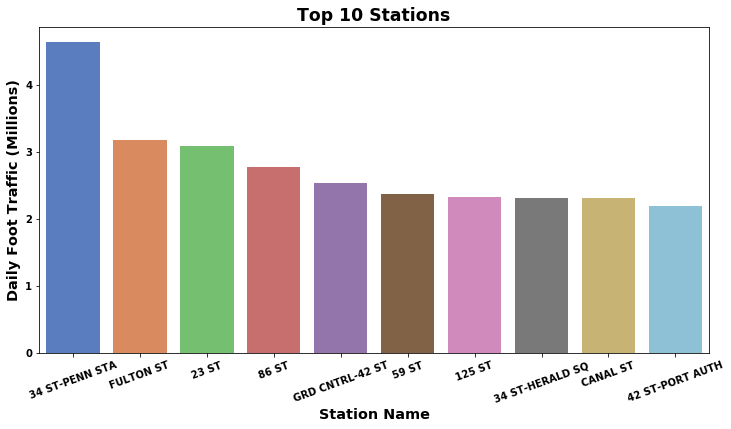

In [36]:
# Top 10 Stations Plot

plt.figure(figsize=[12, 6])
font = {'family': 'sans-serif', 'weight': 'bold'}
plt.rc('font', **font)

ax1 = sns.barplot(x = 'STATION', y = total_foottraffic_top10['DIFF_FOOTTRAFFIC_TOTAL']/1e6,
                  data = total_foottraffic_top10,
                  palette = "muted",)
plt.xticks(rotation=20)
ax1.set_xlabel('Station Name', fontdict=font, fontsize='x-large')
ax1.set_ylabel('Daily Foot Traffic (Millions)', fontdict=font, fontsize='x-large')
plt.title('Top 10 Stations', fontdict=font, fontsize='xx-large');

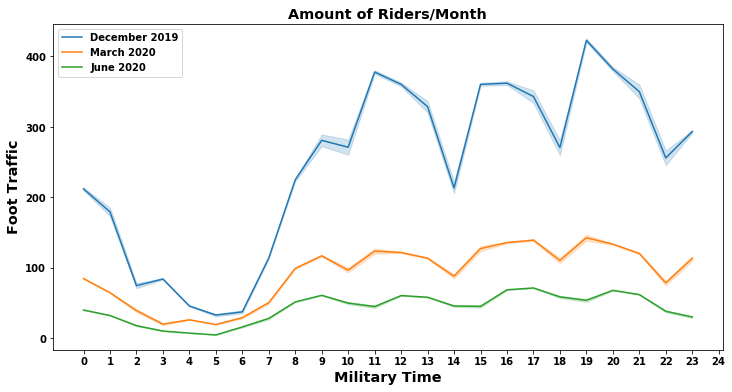

In [35]:
plt.figure(figsize=[12, 6])
font = {'family': 'sans-serif', 'weight': 'bold'}
plt.rc('font', **font)

# December 2019 data
ax1 = sns.lineplot(x = 'ABBREV_TIME', y = df_dec19_4hrfoottraffic['DIFF_FOOTTRAFFIC'],
                  data = df_dec19_4hrfoottraffic,
                  palette = "muted",)

# March 2020 data
sns.lineplot(x = 'ABBREV_TIME', y = df_mar20_4hrfoottraffic['DIFF_FOOTTRAFFIC'],
                     data = df_mar20_4hrfoottraffic,
                     palette = "muted", ax = ax1)

# June 2020 data
sns.lineplot(x = 'ABBREV_TIME', y = df_june20_4hrfoottraffic['DIFF_FOOTTRAFFIC'],
                     data = df_june20_4hrfoottraffic,
                     palette = "muted", ax = ax1)

ax1.set_xlabel('Military Time', fontdict=font, fontsize='x-large')
ax1.set_ylabel('Foot Traffic', fontdict=font, fontsize='x-large')

plt.legend(['December 2019', 'March 2020', 'June 2020'])
plt.xticks(rotation=0)
plt.xticks(np.arange(0, 25, 1.0))
plt.title('Amount of Riders/Month', fontdict=font, fontsize='x-large');